In [3]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os
import torch.nn.functional as F
import numpy as np
import torch.utils.data as Data
from PIL import  Image,ImageDraw
import numpy as np
import random
import cv2
from torchvision import models
from torchsummary import summary

Batch_Size = 50
num_epochs = 200
learning_rate = 1e-5
samples = 20000

data1 = []
data2= []


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% --  Generate dataset
uframes = []
vidcap = cv2.VideoCapture('C:\\Users\\darshan19\\Downloads\\atari\\atari_2_vehicles.avi')
success,image = vidcap.read()
while success:
    uframes.append(image)   
    success,image = vidcap.read()


for i,frame in enumerate(uframes):
    uframes[i] = cv2.resize(frame,(100,100))
    
print(np.shape(uframes[0]))

print("length: ",len(uframes))
for i in range(samples):
    data1.append(np.array(np.transpose(np.asarray(uframes[i % len(uframes)]),(2,0,1)),dtype=np.float32))
    data2.append(np.array(np.transpose(np.asarray(uframes[(i+1) % len(uframes)]),(2,0,1)),dtype=np.float32))



#%%%%%%%%%%%%%%%%%%%%%%%%%%% Noisy data
img = Image.new('RGB', (100,100), color = '#9b7653')
im_n = np.reshape(img,(100,100,3))
b = np.asarray(im_n)
b = np.array(b, dtype=np.float32)
b = np.transpose(b,(2,0,1))
b = torch.from_numpy(b)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%       

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% - Data Preparation

y0 = np.asarray(data1)
y1 = np.asarray(data2)


print(np.shape(y0))

x = torch.from_numpy(y0)
y = torch.from_numpy(y1)


torch_dataset = Data.TensorDataset(x,y)


loader = Data.DataLoader(

    dataset=torch_dataset,

    batch_size=Batch_Size,

    shuffle=True,

    num_workers=0,

)
    


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% - Defining NN
    
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=10, stride=1)
        self.relu1 = nn.ReLU()

        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=5)

        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(5184, 15)
        self.sigmoid1 = nn.Sigmoid()

    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        im_out = out
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.sigmoid1(out)
        return im_out,out
    
model = CNNModel()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% - Loss Function

def h_score(fx, gy):
    fx = fx - fx.mean(0)
    gy = gy - gy.mean(0)
    Nsamples = fx.size(0)
    covf = torch.matmul(fx.t(), fx) / Nsamples
    covg = torch.matmul(gy.t(), gy) / Nsamples
    h = -2 * torch.mean((fx * gy).sum(1)) + (covf * covg).sum()
    return h

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)

for epoch in range(num_epochs):
    for x,y in loader:
        optimizer.zero_grad()
        # ===================forward=====================
        loss = h_score(model(x)[1],model(y)[1])
        # ===================backward====================
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))


KeyboardInterrupt: 

In [9]:
# Author: Atanu Sarkar
# Space Invaders (my version)
# v1.1.4
# 11-April-2020, 03:04 AM (IST)

import pygame
import random
import math
from pygame import mixer
import time

# import sched
flag = False
# game constants
WIDTH = 800
HEIGHT = 600

# global variables
running = True
pause_state = 0
score = 0
highest_score = 0
life = 3
kills = 0
difficulty = 1
level = 1
max_kills_to_difficulty_up = 5
max_difficulty_to_level_up = 5
initial_player_velocity = 3.0
initial_enemy_velocity = 1.0
weapon_shot_velocity = 5.0
single_frame_rendering_time = 0
total_time = 0
frame_count = 0
fps = 0

# game objects
player = type('Player', (), {})()
bullet = type('Bullet', (), {})()
enemies = []
lasers = []

# initialize pygame
pygame.init()

# Input key states (keyboard)
LEFT_ARROW_KEY_PRESSED = 0
RIGHT_ARROW_KEY_PRESSED = 0
UP_ARROW_KEY_PRESSED = 0
SPACE_BAR_PRESSED = 0
ENTER_KEY_PRESSED = 0
ESC_KEY_PRESSED = 0

# create display window
window = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Space Invaders")
window_icon = pygame.image.load("res/images/alien.png")
pygame.display.set_icon(window_icon)

# game sounds
pause_sound = None
level_up_sound = None
weapon_annihilation_sound = None
game_over_sound = None

# create background
background_img = pygame.image.load("res/images/background.jpg")  # 800 x 600 px image
background_music_paths = ["res/sounds/Space_Invaders_Music.ogg",
                          "res/sounds/Space_Invaders_Music_x2.ogg",
                          "res/sounds/Space_Invaders_Music_x4.ogg",
                          "res/sounds/Space_Invaders_Music_x8.ogg",
                          "res/sounds/Space_Invaders_Music_x16.ogg",
                          "res/sounds/Space_Invaders_Music_x32.ogg"]


def init_background_music():
    if difficulty == 1:
        mixer.quit()
        mixer.init()
    if difficulty <= 6:
        mixer.music.load(background_music_paths[difficulty - 1])
    else:
        mixer.music.load(background_music_paths[5])
    mixer.music.play(-1)


# create player class
class Player:
    def __init__(self, img_path, width, height, x, y, dx, dy, kill_sound_path):
        self.img_path = img_path
        self.img = pygame.image.load(self.img_path)
        self.width = width
        self.height = height
        self.x = x
        self.y = y
        self.dx = dx
        self.dy = dy
        self.kill_sound_path = kill_sound_path
        self.kill_sound = mixer.Sound(self.kill_sound_path)

    def draw(self):
        window.blit(self.img, (self.x, self.y))


# create enemy class
class Enemy:
    def __init__(self, img_path,img_reloading_path, width, height, x, y, dx, dy, kill_sound_path):
        self.img_path = img_path
        self.img = pygame.image.load(self.img_path)
        self.reloading = False
        self.img_reloading_path = img_reloading_path
        self.img_reloadig = pygame.image.load(self.img_reloading_path)
        self.width = width
        self.height = height
        self.x = x
        self.y = y
        self.dx = dx
        self.dy = dy
        self.kill_sound_path = kill_sound_path
        self.kill_sound = mixer.Sound(self.kill_sound_path)

    def draw(self):
        if self.reloading == True:
            window.blit(self.img_reloadig, (self.x, self.y))
        else:
            window.blit(self.img, (self.x, self.y))


# create bullet class
class Bullet:
    def __init__(self, img_path, width, height, x, y, dx, dy, fire_sound_path):
        self.img_path = img_path
        self.img = pygame.image.load(self.img_path)
        self.width = width
        self.height = height
        self.x = x
        self.y = y
        self.dx = dx
        self.dy = dy
        self.fired = False
        self.fire_sound_path = fire_sound_path
        self.fire_sound = mixer.Sound(self.fire_sound_path)

    def draw(self):
        if self.fired:
            window.blit(self.img, (self.x, self.y))


# create laser class
class Laser:
    def __init__(self, img_path, width, height, x, y, dx, dy, shoot_probability, relaxation_time, beam_sound_path):
        self.img_path = img_path
        self.img = pygame.image.load(self.img_path)
        self.width = width
        self.height = height
        self.x = x
        self.y = y
        self.dx = dx
        self.dy = dy
        self.beamed = False
        self.shoot_probability = shoot_probability
        self.shoot_timer = 0
        self.relaxation_time = relaxation_time
        self.beam_sound_path = beam_sound_path
        self.beam_sound = mixer.Sound(self.beam_sound_path)

    def draw(self):
        if self.beamed:
            window.blit(self.img, (self.x, self.y))


def scoreboard():
    x_offset = 10
    y_offset = 10
    # set font type and size
    font = pygame.font.SysFont("calibre", 16)

    # render font and text sprites
    score_sprint = font.render("SCORE : " + str(score), True, (255, 255, 255))
    highest_score_sprint = font.render("HI-SCORE : " + str(highest_score), True, (255, 255, 255))
    level_sprint = font.render("LEVEL : " + str(level), True, (255, 255, 255))
    difficulty_sprint = font.render("DIFFICULTY : " + str(difficulty), True, (255, 255, 255))
    life_sprint = font.render("LIFE LEFT : " + str(life) + " | " + ("@ " * life), True, (255, 255, 255))

    # performance info
    fps_sprint = font.render("FPS : " + str(fps), True, (255, 255, 255))
    frame_time_in_ms = round(single_frame_rendering_time * 1000, 2)
    frame_time_sprint = font.render("FT : " + str(frame_time_in_ms) + " ms", True, (255, 255, 255))

    # place the font sprites on the screen
    window.blit(score_sprint, (x_offset, y_offset))
    window.blit(highest_score_sprint, (x_offset, y_offset + 20))
    window.blit(level_sprint, (x_offset, y_offset + 40))
    window.blit(difficulty_sprint, (x_offset, y_offset + 60))
    window.blit(life_sprint, (x_offset, y_offset + 80))
    window.blit(fps_sprint, (WIDTH - 80, y_offset))
    window.blit(frame_time_sprint, (WIDTH - 80, y_offset + 20))


def collision_check(object1, object2):
    x1_cm = object1.x + object1.width / 2
    y1_cm = object1.y + object1.width / 2
    x2_cm = object2.x + object2.width / 2
    y2_cm = object2.y + object2.width / 2
    distance = math.sqrt(math.pow((x2_cm - x1_cm), 2) + math.pow((y2_cm - y1_cm), 2))
    return distance < ((object1.width + object2.width) / 2)


# def collision_check(object1_x, object1_y, object1_diameter, object2_x, object2_y, object2_diameter):
#     x1_cm = object1_x + object1_diameter / 2
#     y1_cm = object1_y + object1_diameter / 2
#     x2_cm = object2_x + object2_diameter / 2
#     y2_cm = object2_y + object2_diameter / 2
#     distance = math.sqrt(math.pow((x2_cm - x1_cm), 2) + math.pow((y2_cm - y1_cm), 2))
#     return distance < ((object1_diameter + object2_diameter) / 2)


def level_up():
    global life
    global level
    global difficulty
    global max_difficulty_to_level_up
    level_up_sound.play()
    level += 1
    life += 1       # grant a life
    difficulty = 1  # reset difficulty
    # TODO: change player and bullet speeds, enemy laser speed and firing probability wrt level
    #  come up with interesting gameplay ideas.
    #  variables in hand:
    #  1. speed of weapons
    #  2. enemy (up to 6) & player velocity
    #  3. laser firing probability
    #  future ideas:
    #  1. add new type of enemies
    #  2. add new player spaceship and bullets!
    #  future features:
    #  1. create player profile ad store highest score to DB
    #  2. multiplayer
    if level % 3 == 0:
        player.dx += 1
        bullet.dy += 1
        max_difficulty_to_level_up += 1
        for each_laser in lasers:
            each_laser.shoot_probability += 0.1
            if each_laser.shoot_probability > 1.0:
                each_laser.shoot_probability = 1.0
    if max_difficulty_to_level_up > 7:
        max_difficulty_to_level_up = 7

    font = pygame.font.SysFont("freesansbold", 64)
    gameover_sprint = font.render("LEVEL UP", True, (255, 255, 255))
    window.blit(gameover_sprint, (WIDTH / 2 - 120, HEIGHT / 2 - 32))
    pygame.display.update()
    init_game()
    time.sleep(1.0)


def respawn(enemy_obj):
    enemy_obj.x = random.randint(0, (WIDTH - enemy_obj.width))
    enemy_obj.y = random.randint(((HEIGHT / 10) * 1 - (enemy_obj.height / 2)),
                                 ((HEIGHT / 10) * 4 - (enemy_obj.height / 2)))


def kill_enemy(player_obj, bullet_obj, enemy_obj):
    global score
    global kills
    global difficulty
    bullet_obj.fired = False
    enemy_obj.kill_sound.play()
    bullet_obj.x = player_obj.x + player_obj.width / 2 - bullet_obj.width / 2
    bullet_obj.y = player_obj.y + bullet_obj.height / 2
    score = score + 10 * difficulty * level
    kills += 1
    if kills % max_kills_to_difficulty_up == 0:
        difficulty += 1
        if (difficulty == max_difficulty_to_level_up) and (life != 0):
            level_up()
        init_background_music()
    print("Score:", score)
    print("level:", level)
    print("difficulty:", difficulty)
    respawn(enemy_obj)


def rebirth(player_obj):
    player_obj.x = (WIDTH / 2) - (player_obj.width / 2)
    player_obj.y = (HEIGHT / 10) * 9 - (player_obj.height / 2)


def gameover_screen():
    scoreboard()
    font = pygame.font.SysFont("freesansbold", 64)
    gameover_sprint = font.render("GAME OVER", True, (255, 255, 255))
    window.blit(gameover_sprint, (WIDTH / 2 - 140, HEIGHT / 2 - 32))
    pygame.display.update()

    mixer.music.stop()
    game_over_sound.play()
    time.sleep(13.0)
    mixer.quit()


def gameover():
    global running
    global score
    global highest_score

    if score > highest_score:
        highest_score = score

    # console display
    print("----------------")
    print("GAME OVER !!")
    print("----------------")
    print("you died at")
    print("Level:", level)
    print("difficulty:", difficulty)
    print("Your Score:", score)
    print("----------------")
    print("Try Again !!")
    print("----------------")
    running = False
    gameover_screen()


def kill_player(player_obj, enemy_obj, laser_obj):
    global life
    laser_obj.beamed = False
    player_obj.kill_sound.play()
    laser_obj.x = enemy_obj.x + enemy_obj.width / 2 - laser_obj.width / 2
    laser_obj.y = enemy_obj.y + laser_obj.height / 2
    life -= 1
    print("Life Left:", life)
    if life > 0:
        rebirth(player_obj)
    else:
        gameover()


def destroy_weapons(player_obj, bullet_obj, enemy_obj, laser_obj):
    bullet_obj.fired = False
    laser_obj.beamed = False
    weapon_annihilation_sound.play()
    bullet_obj.x = player_obj.x + player_obj.width / 2 - bullet_obj.width / 2
    bullet_obj.y = player_obj.y + bullet_obj.height / 2
    laser_obj.x = enemy_obj.x + enemy_obj.width / 2 - laser_obj.width / 2
    laser_obj.y = enemy_obj.y + laser_obj.height / 2


# timer = sched.scheduler(time.time, time.sleep)
#
#
# def calculate_fps(sc):
#     global frame_count
#     fps = frame_count
#     print("FPS =", fps)
#     frame_count = 0
#     timer.enter(60, 1, calculate_fps, (sc,))
#
#
# timer.enter(60, 1, calculate_fps, (timer, ))
# timer.run()


def pause_game():
    pause_sound.play()
    scoreboard()
    font = pygame.font.SysFont("freesansbold", 64)
    gameover_sprint = font.render("PAUSED", True, (255, 255, 255))
    window.blit(gameover_sprint, (WIDTH / 2 - 80, HEIGHT / 2 - 32))
    pygame.display.update()
    mixer.music.pause()


def init_game():
    global pause_sound
    global level_up_sound
    global game_over_sound
    global weapon_annihilation_sound

    pause_sound = mixer.Sound("res/sounds/pause.wav")
    level_up_sound = mixer.Sound("res/sounds/1up.wav")
    game_over_sound = mixer.Sound("res/sounds/gameover.wav")
    weapon_annihilation_sound = mixer.Sound("res/sounds/annihilation.wav")

    # player
    player_img_path = "res/images/spaceship.png"  # 64 x 64 px image
    player_width = 64
    player_height = 64
    player_x = (WIDTH / 2) - (player_width / 2)
    player_y = (HEIGHT / 10) * 9 - (player_height / 2)
    player_dx = initial_player_velocity
    player_dy = 0
    player_kill_sound_path = "res/sounds/explosion.wav"

    global player
    player = Player(player_img_path, player_width, player_height, player_x, player_y, player_dx, player_dy,
                    player_kill_sound_path)

    # bullet
    bullet_img_path = "res/images/bullet.png"  # 32 x 32 px image
    bullet_width = 32
    bullet_height = 32
    bullet_x = player_x + player_width / 2 - bullet_width / 2
    bullet_y = player_y + bullet_height / 2
    bullet_dx = 0
    bullet_dy = weapon_shot_velocity
    bullet_fire_sound_path = "res/sounds/gunshot.wav"

    global bullet
    bullet = Bullet(bullet_img_path, bullet_width, bullet_height, bullet_x, bullet_y, bullet_dx, bullet_dy,
                    bullet_fire_sound_path)

    # enemy (number of enemy = level number)
    enemy_img_path = "res/images/enemy1.jpg"  # 64 x 64 px image
    enemy_width = 64
    enemy_height = 64
    enemy_dx = initial_enemy_velocity
    enemy_dy = (HEIGHT / 10) / 2
    enemy_kill_sound_path = "res/sounds/enemykill.wav"

    # enemy reloading (number of enemy = level number)
    enemy_reloading_img_path = "res/images/enemy_reloading.jpg"  # 64 x 64 px image


    # laser beam (equals number of enemies and retains corresponding enemy position)
    laser_img_path = "res/images/beam.png"  # 24 x 24 px image
    laser_width = 24
    laser_height = 24
    laser_dx = 0
    laser_dy = weapon_shot_velocity
    shoot_probability = 0.3
    relaxation_time = 100
    laser_beam_sound_path = "res/sounds/laser.wav"

    global enemies
    global lasers

    enemies.clear()
    lasers.clear()

    for lev in range(level):
        enemy_x = random.randint(0, (WIDTH - enemy_width))
        enemy_y = random.randint(((HEIGHT / 10) * 1 - (enemy_height / 2)), ((HEIGHT / 10) * 4 - (enemy_height / 2)))
        laser_x = enemy_x + enemy_width / 2 - laser_width / 2
        laser_y = enemy_y + laser_height / 2

        enemy_obj = Enemy(enemy_img_path,enemy_reloading_img_path, enemy_width, enemy_height, enemy_x, enemy_y, enemy_dx, enemy_dy,
                          enemy_kill_sound_path)

        enemies.append(enemy_obj)

        laser_obj = Laser(laser_img_path, laser_width, laser_height, laser_x, laser_y, laser_dx, laser_dy,
                          shoot_probability, relaxation_time, laser_beam_sound_path)
        lasers.append(laser_obj)
        #lasers.append(laser_obj)


# init game
init_game()
init_background_music()
runned_once = False

# main game loop begins
while running:
    # start of frame timing
    start_time = time.time()

    # background
    window.fill((0, 0, 0))
    window.blit(background_img, (0, 0))

    # register events
    for event in pygame.event.get():
        # Quit Event
        if event.type == pygame.QUIT:
            running = False

        # Keypress Down Event
        if event.type == pygame.KEYDOWN:
            # Left Arrow Key down
            if event.key == pygame.K_LEFT:
                print("LOG: Left Arrow Key Pressed Down")
                LEFT_ARROW_KEY_PRESSED = 1
            # Right Arrow Key down
            if event.key == pygame.K_RIGHT:
                print("LOG: Right Arrow Key Pressed Down")
                RIGHT_ARROW_KEY_PRESSED = 1
            # Up Arrow Key down
            if event.key == pygame.K_UP:
                print("LOG: Up Arrow Key Pressed Down")
                UP_ARROW_KEY_PRESSED = 1
            # Space Bar down
            if event.key == pygame.K_SPACE:
                print("LOG: Space Bar Pressed Down")
                SPACE_BAR_PRESSED = 1
            # Enter Key down ("Carriage RETURN key" from old typewriter lingo)
            if event.key == pygame.K_RETURN:
                print("LOG: Enter Key Pressed Down")
                ENTER_KEY_PRESSED = 1
                pause_state += 1
            # Esc Key down
            if event.key == pygame.K_ESCAPE:
                print("LOG: Escape Key Pressed Down")
                ESC_KEY_PRESSED = 1
                pause_state += 1

        # Keypress Up Event
        if event.type == pygame.KEYUP:
            # Right Arrow Key up
            if event.key == pygame.K_RIGHT:
                print("LOG: Right Arrow Key Released")
                RIGHT_ARROW_KEY_PRESSED = 0
            # Left Arrow Key up
            if event.key == pygame.K_LEFT:
                print("LOG: Left Arrow Key Released")
                LEFT_ARROW_KEY_PRESSED = 0
            # Up Arrow Key up
            if event.key == pygame.K_UP:
                print("LOG: Up Arrow Key Released")
                UP_ARROW_KEY_PRESSED = 0
            # Space Bar up
            if event.key == pygame.K_SPACE:
                print("LOG: Space Bar Released")
                SPACE_BAR_PRESSED = 0
            # Enter Key up ("Carriage RETURN key" from old typewriter lingo)
            if event.key == pygame.K_RETURN:
                print("LOG: Enter Key Released")
                ENTER_KEY_PRESSED = 0
            # Esc Key up
            if event.key == pygame.K_ESCAPE:
                print("LOG: Escape Key Released")
                ESC_KEY_PRESSED = 0

    # check for pause game event
    if pause_state == 2:
        pause_state = 0
        runned_once = False
        mixer.music.unpause()
    if pause_state == 1:
        if not runned_once:
            runned_once = True
            pause_game()
        continue
    # manipulate game objects based on events and player actions
    # player spaceship movement
    if RIGHT_ARROW_KEY_PRESSED:
        player.x += player.dx
    if LEFT_ARROW_KEY_PRESSED:
        player.x -= player.dx
    # bullet firing
    if (SPACE_BAR_PRESSED or UP_ARROW_KEY_PRESSED) and not bullet.fired:
        bullet.fired = True
        bullet.fire_sound.play()
        bullet.x = player.x + player.width / 2 - bullet.width / 2
        bullet.y = player.y + bullet.height / 2
    # bullet movement
    if bullet.fired:
        bullet.y -= bullet.dy

    # iter through every enemies and lasers
    for i in range(len(enemies)):
        # laser beaming
        if not lasers[i].beamed:
            lasers[i].shoot_timer += 1
            if lasers[i].shoot_timer == lasers[i].relaxation_time:
                lasers[i].shoot_timer = 0
                random_chance = random.randint(0, 100)
                if random_chance <= (lasers[i].shoot_probability * 100):
                    #enemies[i].reloading = False
                    lasers[i].beamed = True
                    lasers[i].beam_sound.play()
                    lasers[i].x = enemies[i].x + enemies[i].width / 2 - lasers[i].width / 2
                    lasers[i].y = enemies[i].y + lasers[i].height / 2
        # enemy movement
        #enemies[i].reloading = False

        enemies[i].x += enemies[i].dx * float(2 ** (difficulty - 1))
        # laser movement
        if lasers[i].beamed:
            enemies[i].reloading = True
            lasers[i].y += lasers[i].dy

    # collision check
    for i in range(len(enemies)):
        bullet_enemy_collision = collision_check(bullet, enemies[i])
        if bullet_enemy_collision:
            kill_enemy(player, bullet, enemies[i])

    for i in range(len(lasers)):
        laser_player_collision = collision_check(lasers[i], player)
        if laser_player_collision:
            kill_player(player, enemies[i], lasers[i])

    for i in range(len(enemies)):
        enemy_player_collision = collision_check(enemies[i], player)
        if enemy_player_collision:
            kill_enemy(player, bullet, enemies[i])
            kill_player(player, enemies[i], lasers[i])

    for i in range(len(lasers)):
        bullet_laser_collision = collision_check(bullet, lasers[i])
        if bullet_laser_collision:
            destroy_weapons(player, bullet, enemies[i], lasers[i])

    # boundary check: 0 <= x <= WIDTH, 0 <= y <= HEIGHT
    # player spaceship
    if player.x < 0:
        player.x = 0
    if player.x > WIDTH - player.width:
        player.x = WIDTH - player.width
    # enemy
    for enemy in enemies:
        if enemy.x <= 0:
            enemy.dx = abs(enemy.dx) * 1
            enemy.y += enemy.dy
        if enemy.x >= WIDTH - enemy.width:
            enemy.dx = abs(enemy.dx) * -1
            enemy.y += enemy.dy
    # bullet
    if bullet.y < 0:
        bullet.fired = False
        bullet.x = player.x + player.width / 2 - bullet.width / 2
        bullet.y = player.y + bullet.height / 2
    # laser
    for i in range(len(lasers)):
        if lasers[i].y > HEIGHT:
            lasers[i].beamed = False
            lasers[i].x = enemies[i].x + enemies[i].width / 2 - lasers[i].width / 2
            lasers[i].y = enemies[i].y + lasers[i].height / 2

    # create frame by placing objects on the surface
    scoreboard()


    for enemy in enemies:
        enemy.draw()
    for laser in lasers:
        laser.draw()
    bullet.draw()
    player.draw()

    # render the display
    pygame.display.update()

    for enemy in enemies:
        enemy.reloading = False
        enemy.draw()



    #pygame.display.update()
    # end of rendering, end on a frame
    frame_count += 1
    end_time = time.time()
    single_frame_rendering_time = end_time - start_time
    # fps = 1 / render_time


    total_time = total_time + single_frame_rendering_time
    if total_time >= 1.0:
        fps = frame_count
        frame_count = 0
        total_time = 0
    # print("rendering time:", single_frame_rendering_time)
    # print("FPS:", fps)


pygame 2.0.1 (SDL 2.0.14, Python 3.7.7)
Hello from the pygame community. https://www.pygame.org/contribute.html
Life Left: 2


In [68]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

tank_moving_panels={}
tank_reloading_panels={}
tmtr_panels={}

uframes = []
vidcap = cv2.VideoCapture('C:\\Users\\darshan19\\Downloads\\atari\\atari_2_vehicles.avi')
success,image = vidcap.read()
while success:
    uframes.append(image)   
    success,image = vidcap.read()
for i,frame in enumerate(uframes):
    uframes[i] = cv2.resize(frame,(100,100))

num_channels = 16
buffer = 5

tmtr = 38
tm = 4
tr = 46

def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    return value,position

def image_to_numpy(img):
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    return output


for i in range(num_channels):

    
    output = image_to_numpy(uframes[tmtr])
    tmtr_panel = output[0][i]
    val_tmtr,pos_tmtr = val_pos(tmtr_panel)
    print("Tank Moving Tank Reloading Panel: ",val_tmtr,pos_tmtr)
    print("**********")
    
    output = image_to_numpy(uframes[tm])
    tm_panel = output[0][i]
    val_tm,pos_tm = val_pos(tm_panel)
    print("Tank Moving Panel: ",val_tm,pos_tm)
    print("**********")
    
    
    output = image_to_numpy(uframes[tr])
    tr_panel = output[0][i]
    val_tr,pos_tr = val_pos(tr_panel)
    print("Tank Reloading Panel: ",val_tr,pos_tr)
    print("**********")
    
       
    print("\nPanel ",i)
    print("\n++++++++++++++++++++++++++++++++++++++++++++\n")
    
    if val_tm > max(val_tmtr,val_tr):
        tank_moving_panels[i] = val_tm - buffer
    elif val_tr > max(val_tmtr,val_tm):
        tank_reloading_panels[i] = val_tr - buffer
    elif val_tmtr > max(val_tr,val_tm):
        tmtr_panels[i] = val_tmtr - buffer
        

print("\nTank Moving: \n", tank_moving_panels)
print("\nTank Reloading: \n", tank_reloading_panels)
print("\nTank Moving and Reloading\n",tmtr_panels)


Tank Moving Tank Reloading Panel:  2494.647 (5, 2)
**********
Tank Moving Panel:  2737.3694 (5, 0)
**********
Tank Reloading Panel:  2088.777 (4, 3)
**********

Panel  0

++++++++++++++++++++++++++++++++++++++++++++

Tank Moving Tank Reloading Panel:  2625.3337 (6, 3)
**********
Tank Moving Panel:  2742.047 (6, 1)
**********
Tank Reloading Panel:  2659.1826 (4, 4)
**********

Panel  1

++++++++++++++++++++++++++++++++++++++++++++

Tank Moving Tank Reloading Panel:  2153.336 (0, 0)
**********
Tank Moving Panel:  2399.495 (6, 15)
**********
Tank Reloading Panel:  1861.6968 (5, 4)
**********

Panel  2

++++++++++++++++++++++++++++++++++++++++++++

Tank Moving Tank Reloading Panel:  3101.5125 (4, 1)
**********
Tank Moving Panel:  2978.5002 (4, 0)
**********
Tank Reloading Panel:  2606.192 (4, 2)
**********

Panel  3

++++++++++++++++++++++++++++++++++++++++++++

Tank Moving Tank Reloading Panel:  2132.3364 (6, 3)
**********
Tank Moving Panel:  2195.0789 (6, 1)
**********
Tank Reloading Pan

In [95]:
import cv2


cap = cv2.VideoCapture('C:\\Users\\darshan19\\Downloads\\atari\\atari_2_vehicles.avi')

fps = int(cap.get(1))

frame_width = int(cap.get(3))

frame_height = int(cap.get(4))

print(frame_width,frame_height)
tankrc=[]
tankm=[]
tankrc1=[]
tank_moving_panels = {0: 2732.369384765625, 1: 2737.047119140625, 2: 2394.4951171875, 4: 2190.078857421875, 
                      7: 2297.058837890625, 9: 2978.161376953125, 11: 2600.28759765625, 15: 2298.097412109375}
tank_reloading_panels = {5: 3207.76171875, 6: 2881.5322265625, 8: 1940.783203125, 
                         10: 2830.391845703125, 12: 1608.0382080078125, 14: 3129.3603515625}

tmtr_panels = {3: 3096.512451171875, 13: 2212.85302734375}

keys = list(tank_reloading_panels.keys())
keys_tmtr  = list(tmtr_panels.keys())
keys_tm = list(tank_moving_panels.keys())

uframes=[]
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
flag1=False
flag2 = False
flag3 = False
out = cv2.VideoWriter('Two Aliens.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10,(frame_width,frame_height))

def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    return value,position
ret, frame = cap.read()

while(ret):
    #Capture frames in the video
    #describe the type of font
    #to be used.
    font = cv2.FONT_HERSHEY_SIMPLEX
    #Use putText() method for
    #inserting text on video
    #print(np.shape(frame))
    uframes=[]
    flag1=False
    flag2 = False
    flag3 = False
    uframes.append(cv2.resize(frame,(100,100)))
    img = uframes[0]
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1.reshape(1,3,100, 100))[0].detach().numpy()
    
    for key in keys_tm:
        output_tankr = output[0][key]
        val_tankr,pos_tankr = val_pos(output_tankr)
        if  val_tankr>tank_moving_panels[key]:
            tankm.append(pos_tankr)
            flag1=True
            break

    if flag1 == False:
        for key in keys:
            output_tankr = output[0][key]
            val_tankr,pos_tankr = val_pos(output_tankr)
            if val_tankr>tank_reloading_panels[key]:
                tankrc.append(pos_tankr)
                flag2 = True
                break


    if flag2 == False:
        for key in keys_tmtr:
            output_tankr = output[0][key]
            val_tankr,pos_tankr = val_pos(output_tankr)
            if  val_tankr>tmtr_panels[key]:
                tankrc1.append(pos_tankr)
                break


    ret, frame = cap.read()

# release the cap object
cap.release()
# close all windows
cv2.destroyAllWindows()

1770 1328


<function matplotlib.pyplot.show(*args, **kw)>

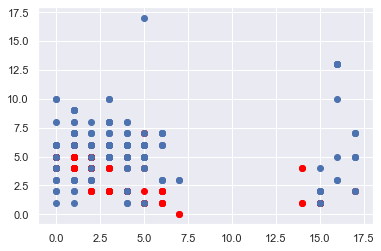

In [97]:
import numpy as np
import matplotlib.pyplot as plt

x1 = [tankrc[i][0] for i in range(len(tankrc))]
y1 = [tankrc[i][1] for i in range(len(tankrc))]

# x2 = [tankm[i][0] for i in range(len(tankm))]
# y2 = [tankm[i][1] for i in range(len(tankm))]




x2 = [tankrc1[i][0] for i in range(len(tankrc))]
y2 = [tankrc1[i][1] for i in range(len(tankrc))]

# plt.scatter(y3,x3,color='black')
plt.scatter(y2,x2,color='red')
plt.scatter(y1,x1)


plt.show

In [91]:
import cv2


cap = cv2.VideoCapture('C:\\Users\\darshan19\\Downloads\\atari\\atari_2_vehicles.avi')

fps = int(cap.get(1))

frame_width = int(cap.get(3))

frame_height = int(cap.get(4))

print(frame_width,frame_height)
tankrc=[]
tankrc1=[]

tank_moving_panels = {0: 2939.852294921875, 1: 3651.266845703125, 2: 3918.51708984375, 
                      4: 2535.77880859375, 6: 2757.001953125, 8: 1897.1790771484375, 
                      12: 2739.127685546875, 15: 2944.8779296875}

tank_reloading_panels = {3: 2042.2137451171875, 5: 2765.12841796875, 
                         7: 3176.161376953125, 10: 2638.602783203125, 11: 3490.5673828125, 14: 1660.1922607421875}

tmtr_panels = {9: 2719.021484375, 13: 3320.355712890625}

keys = list(tank_reloading_panels.keys())
keys_tmtr  = list(tmtr_panels.keys())
keys_tm = list(tank_moving_panels.keys())

uframes=[]
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.

out = cv2.VideoWriter('Two Aliens.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10,(frame_width,frame_height))

def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    scaled_position = (position[1]*73,position[0]*98)
    return value,scaled_position
ret, frame = cap.read()

while(ret):
    #Capture frames in the video
    #describe the type of font
    #to be used.
    font = cv2.FONT_HERSHEY_SIMPLEX
    #Use putText() method for
    #inserting text on video
    #print(np.shape(frame))
    uframes=[]
    flag = False
    uframes.append(cv2.resize(frame,(100,100)))
    img = uframes[0]
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1.reshape(1,3,100, 100))[0].detach().numpy()

    for key in keys:
        output_tankr = output[0][key]
        val_tankr,pos_tankr = val_pos(output_tankr)
        if val_tankr>tank_reloading_panels[key]:
            #print("tank reloading present")
            tankrc.append(pos_tankr)
            flag = True
            break
            #l.append(i)
            # Display the resulting frame
    if flag == False:
        for key in keys_tmtr:
            output_tankr = output[0][key]
            val_tankr,pos_tankr = val_pos(output_tankr)
            if  val_tankr>tmtr_panels[key]:
                #print("tank reloading present")
                tankrc1.append(pos_tankr)
                break
                #l.append(i)
                # Display the resulting frame


    out.write(frame)
    ret, frame = cap.read()

# release the cap object
cap.release()
# close all windows
cv2.destroyAllWindows()

1770 1328


In [109]:
t1 =[]

for i in tankrc:
    t1.append(list(i))
    
t2 =[]

for i in tankrc1:
    t2.append(list(i))
    
print("T1 ",t1)
print("T2 ",t2)

T1  [[5, 3], [5, 3], [4, 2], [6, 3], [6, 2], [6, 2], [6, 3], [6, 3], [6, 3], [5, 3], [5, 3], [5, 3], [5, 3], [6, 4], [6, 4], [6, 3], [6, 3], [6, 4], [6, 4], [6, 4], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [6, 5], [6, 6], [6, 6], [1, 15], [1, 15], [5, 17], [5, 17], [5, 17], [5, 0], [5, 0], [5, 2], [6, 1], [6, 1], [4, 0], [6, 1], [6, 1], [4, 0], [4, 0], [6, 0], [6, 0], [6, 0], [7, 17], [6, 0], [6, 0], [4, 15], [7, 6], [7, 6], [7, 6], [7, 6], [7, 5], [2, 15], [2, 15], [6, 6], [6, 5], [6, 5], [6, 5], [6, 5], [6, 5], [6, 5], [6, 5], [6, 4], [6, 4], [7, 3], [6, 3], [6, 3], [6, 3], [1, 1], [3, 0], [3, 0], [3, 0], [3, 1], [3, 1], [3, 1], [2, 0], [2, 0], [7, 17], [3, 1], [3, 1], [7, 17], [2, 1], [2, 1], [3, 2], [3, 2], [3, 2], [3, 2], [8, 0], [10, 0], [10, 0], [9, 1], [9, 1], [9, 1], [8, 1], [8, 1], [9, 1], [9, 1], [8, 3], [8, 3], [8, 3], [10, 3], [10, 3], [8, 3], [8, 3], [8, 4], [8, 4], [3, 7], [3, 7], [3, 6], [3, 6], [4, 5], [4, 5], [5, 16], [5, 3], [5, 3], [17, 5], [5, 3], [5, 3], [7

In [107]:
import seaborn as sns
from tqdm import trange
sns.set()

class MyRnn(nn.Module):
  def __init__(self, in_d=2, out_d=2, hidden_d=4, num_hidden=1):
    super(MyRnn, self).__init__()
    self.rnn = nn.RNN(input_size=in_d, hidden_size=hidden_d, num_layers=num_hidden)
    self.fc = nn.Linear(hidden_d, out_d)

  def forward(self, x, h0):
    r, h = self.rnn(x, h0)
    y = self.fc(r)  # no activation on the output
    return y, h

s1 = torch.tensor(tankrc, dtype=torch.float)[:, None, :] 
s2 = torch.tensor(tankrc1,dtype=torch.float)[:, None, :]


print("S1: ", s1)
print("\nS2: ", s2)

S1:  tensor([[[ 5.,  3.]],

        [[ 5.,  3.]],

        [[ 4.,  2.]],

        [[ 6.,  3.]],

        [[ 6.,  2.]],

        [[ 6.,  2.]],

        [[ 6.,  3.]],

        [[ 6.,  3.]],

        [[ 6.,  3.]],

        [[ 5.,  3.]],

        [[ 5.,  3.]],

        [[ 5.,  3.]],

        [[ 5.,  3.]],

        [[ 6.,  4.]],

        [[ 6.,  4.]],

        [[ 6.,  3.]],

        [[ 6.,  3.]],

        [[ 6.,  4.]],

        [[ 6.,  4.]],

        [[ 6.,  4.]],

        [[ 5.,  5.]],

        [[ 5.,  5.]],

        [[ 5.,  5.]],

        [[ 5.,  5.]],

        [[ 5.,  5.]],

        [[ 5.,  5.]],

        [[ 6.,  5.]],

        [[ 6.,  6.]],

        [[ 6.,  6.]],

        [[ 1., 15.]],

        [[ 1., 15.]],

        [[ 5., 17.]],

        [[ 5., 17.]],

        [[ 5., 17.]],

        [[ 5.,  0.]],

        [[ 5.,  0.]],

        [[ 5.,  2.]],

        [[ 6.,  1.]],

        [[ 6.,  1.]],

        [[ 4.,  0.]],

        [[ 6.,  1.]],

        [[ 6.,  1.]],

        [[ 4.,  0.]],

      

100%|██████████| 1000/1000 [01:52<00:00,  8.88it/s]


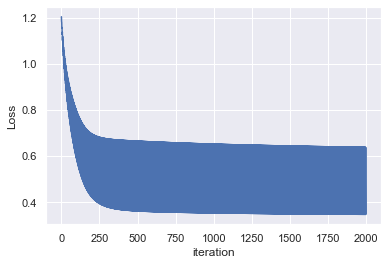

seq 0, prev = tensor([[6., 2.]])  -> predicted 5th step = tensor([[5.9902, 2.2973]]), actual step = tensor([[6., 2.]])
		predicted step 6 (prev = tensor([[[6., 2.]]])) = tensor([[6.2498, 2.9223]]), actual step = tensor([[6., 3.]])
		predicted step 7 (prev = tensor([[[6., 3.]]])) = tensor([[6.1408, 3.4788]]), actual step = tensor([[6., 3.]])
		predicted step 8 (prev = tensor([[[6., 3.]]])) = tensor([[6.1813, 3.5829]]), actual step = tensor([[6., 3.]])
		predicted step 9 (prev = tensor([[[6., 4.]]])) = tensor([[6.2002, 4.5119]]), actual step = tensor([[5., 3.]])
		predicted step 10 (prev = tensor([[[6., 5.]]])) = tensor([[6.1169, 5.2640]]), actual step = tensor([[5., 3.]])
		predicted step 11 (prev = tensor([[[6., 5.]]])) = tensor([[6.1369, 5.4919]]), actual step = tensor([[5., 3.]])
		predicted step 12 (prev = tensor([[[6., 5.]]])) = tensor([[6.1633, 5.6304]]), actual step = tensor([[5., 3.]])
		predicted step 13 (prev = tensor([[[6., 6.]]])) = tensor([[6.1342, 6.4033]]), actual step = 

		predicted step 131 (prev = tensor([[[6., 8.]]])) = tensor([[6.0517, 8.2941]]), actual step = tensor([[6., 5.]])
		predicted step 132 (prev = tensor([[[6., 8.]]])) = tensor([[6.0517, 8.2941]]), actual step = tensor([[13., 16.]])
		predicted step 133 (prev = tensor([[[6., 8.]]])) = tensor([[6.0517, 8.2941]]), actual step = tensor([[13., 16.]])
		predicted step 134 (prev = tensor([[[6., 8.]]])) = tensor([[6.0517, 8.2941]]), actual step = tensor([[13., 16.]])
		predicted step 135 (prev = tensor([[[6., 8.]]])) = tensor([[6.0517, 8.2941]]), actual step = tensor([[13., 16.]])
		predicted step 136 (prev = tensor([[[6., 8.]]])) = tensor([[6.0517, 8.2941]]), actual step = tensor([[13., 16.]])
		predicted step 137 (prev = tensor([[[6., 8.]]])) = tensor([[6.0517, 8.2941]]), actual step = tensor([[1., 0.]])
		predicted step 138 (prev = tensor([[[6., 8.]]])) = tensor([[6.0517, 8.2941]]), actual step = tensor([[ 2., 17.]])
		predicted step 139 (prev = tensor([[[6., 8.]]])) = tensor([[6.0517, 8.2941

		predicted step 95 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[ 2., 17.]])
		predicted step 96 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[5., 3.]])
		predicted step 97 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[5., 3.]])
		predicted step 98 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[5., 3.]])
		predicted step 99 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[5., 2.]])
		predicted step 100 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[5., 2.]])
		predicted step 101 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[5., 2.]])
		predicted step 102 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[5., 2.]])
		predicted step 103 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual ste

		predicted step 238 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[5., 4.]])
		predicted step 239 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[5., 4.]])
		predicted step 240 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[4., 3.]])
		predicted step 241 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[4., 3.]])
		predicted step 242 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[4., 2.]])
		predicted step 243 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[5., 2.]])
		predicted step 244 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[5., 2.]])
		predicted step 245 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[5., 2.]])
		predicted step 246 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual 

		predicted step 371 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[ 0., 16.]])
		predicted step 372 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[ 0., 16.]])
		predicted step 373 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[ 0., 16.]])
		predicted step 374 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[ 1., 15.]])
		predicted step 375 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[1., 5.]])
		predicted step 376 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[1., 5.]])
		predicted step 377 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[1., 5.]])
		predicted step 378 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[1., 5.]])
		predicted step 379 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]),

		predicted step 493 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[2., 5.]])
		predicted step 494 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[3., 5.]])
		predicted step 495 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[3., 5.]])
		predicted step 496 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[3., 5.]])
		predicted step 497 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[3., 4.]])
		predicted step 498 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[4., 3.]])
		predicted step 499 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[3., 3.]])
		predicted step 500 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual step = tensor([[3., 2.]])
		predicted step 501 (prev = tensor([[[4., 1.]]])) = tensor([[4.0846, 1.4398]]), actual 

In [105]:
x = torch.cat((s1,s2),dim=0)
mu = x.mean(dim=0)
sig=x.std(dim=0)
sequences = [(s1-mu)/sig, (s2-mu)/sig]  # pythonic list to hold sequences of un-even length

in_d = s1.shape[-1]
out_d = in_d
hidden_d = 8
num_hidden = 1
rnn = MyRnn(in_d, out_d, hidden_d, num_hidden)
loss = []
criterion = nn.MSELoss()
opt = torch.optim.SGD(rnn.parameters(), lr=0.01)
n_epochs = 1000
for e in trange(n_epochs):
  for s in sequences:
    pred, _ = rnn(s[:-1,...], torch.zeros(num_hidden, 1, hidden_d, dtype=torch.float))  # predict next step, init hidden state to zero at the begining of the sequence
    err = criterion(pred, s[1:, ...])  # predict next step for each step
    opt.zero_grad()
    err.backward()
    opt.step()
    loss.append(err.item())
plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('iteration')
plt.show()

rnn.eval()
with torch.no_grad():
  k = 5 
  for si, s in enumerate(sequences):
    pred, h = rnn(s[:k,...], torch.zeros(num_hidden, 1, hidden_d, dtype=torch.float))  # given first k steps predict the next one
    print('seq {}, prev = {}  -> predicted {}th step = {}, actual step = {}'.format(si, s[k-1,...]*sig+mu, k, pred[-1, ...]*sig + mu, s[k, ...]*sig+mu))
    prev = (torch.round(pred[-1:, ...]*sig + mu) - mu) / sig  # round the prediction, attmepting to avoid accumulation of error
    # continue to predict 
    for j in  range(k+1, s.shape[0]):
      pred, h = rnn(prev, h)
      print('\t\tpredicted step {} (prev = {}) = {}, actual step = {}'.format(j, prev*sig+mu, pred[-1,...]*sig+mu, s[j, ...]*sig + mu))
      prev = (torch.round(pred*sig + mu) - mu) / sig
  print('\n')

In [108]:
rnn.eval()
with torch.no_grad():
  k = 1 
  for si, s in enumerate(sequences):
    pred, h = rnn(s[:k,...], torch.zeros(num_hidden, 1, hidden_d, dtype=torch.float))  # given first k steps predict the next one
    print('seq {}, prev = {}  -> predicted {}th step = {}, actual step = {}'.format(si, s[k-1,...]*sig+mu, k, pred[-1, ...]*sig + mu, s[k, ...]*sig+mu))
    prev = (torch.round(pred[-1:, ...]*sig + mu) - mu) / sig  # round the prediction, attmepting to avoid accumulation of error
    # continue to predict 
    for j in  range(k+1, s.shape[0]):
      pred, h = rnn(prev, h)
      print('\t\tpredicted step {} (prev = {}) = {}, actual step = {}'.format(j, prev*sig+mu, pred[-1,...]*sig+mu, s[j, ...]*sig + mu))
      prev = (torch.round(pred*sig + mu) - mu) / sig
  print('\n')

seq 0, prev = tensor([[5., 3.]])  -> predicted 1th step = tensor([[4.6414, 3.7226]]), actual step = tensor([[5., 3.]])
		predicted step 2 (prev = tensor([[[5., 4.]]])) = tensor([[5.2966, 4.4585]]), actual step = tensor([[4., 2.]])
		predicted step 3 (prev = tensor([[[5., 4.]]])) = tensor([[5.0982, 4.0926]]), actual step = tensor([[6., 3.]])
		predicted step 4 (prev = tensor([[[5., 4.]]])) = tensor([[5.2614, 4.5718]]), actual step = tensor([[6., 2.]])
		predicted step 5 (prev = tensor([[[5., 5.]]])) = tensor([[5.1509, 5.2768]]), actual step = tensor([[6., 2.]])
		predicted step 6 (prev = tensor([[[5., 5.]]])) = tensor([[5.1505, 5.3276]]), actual step = tensor([[6., 3.]])
		predicted step 7 (prev = tensor([[[5., 5.]]])) = tensor([[5.2124, 5.5218]]), actual step = tensor([[6., 3.]])
		predicted step 8 (prev = tensor([[[5., 6.]]])) = tensor([[5.1621, 6.2755]]), actual step = tensor([[6., 3.]])
		predicted step 9 (prev = tensor([[[5., 6.]]])) = tensor([[5.1280, 6.3388]]), actual step = tens

		predicted step 112 (prev = tensor([[[5., 7.]]])) = tensor([[5.1726, 7.4743]]), actual step = tensor([[3., 6.]])
		predicted step 113 (prev = tensor([[[5., 7.]]])) = tensor([[5.1726, 7.4743]]), actual step = tensor([[3., 6.]])
		predicted step 114 (prev = tensor([[[5., 7.]]])) = tensor([[5.1726, 7.4743]]), actual step = tensor([[4., 5.]])
		predicted step 115 (prev = tensor([[[5., 7.]]])) = tensor([[5.1726, 7.4743]]), actual step = tensor([[4., 5.]])
		predicted step 116 (prev = tensor([[[5., 7.]]])) = tensor([[5.1726, 7.4743]]), actual step = tensor([[ 5., 16.]])
		predicted step 117 (prev = tensor([[[5., 7.]]])) = tensor([[5.1726, 7.4743]]), actual step = tensor([[5., 3.]])
		predicted step 118 (prev = tensor([[[5., 7.]]])) = tensor([[5.1726, 7.4743]]), actual step = tensor([[5., 3.]])
		predicted step 119 (prev = tensor([[[5., 7.]]])) = tensor([[5.1726, 7.4743]]), actual step = tensor([[17.,  5.]])
		predicted step 120 (prev = tensor([[[5., 7.]]])) = tensor([[5.1726, 7.4743]]), act

		predicted step 50 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[4., 2.]])
		predicted step 51 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[5., 2.]])
		predicted step 52 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[5., 2.]])
		predicted step 53 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[4., 2.]])
		predicted step 54 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[4., 2.]])
		predicted step 55 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[4., 2.]])
		predicted step 56 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[5., 2.]])
		predicted step 57 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[4., 1.]])
		predicted step 58 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = te

		predicted step 179 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[7., 3.]])
		predicted step 180 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[7., 3.]])
		predicted step 181 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[7., 3.]])
		predicted step 182 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[7., 3.]])
		predicted step 183 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[7., 3.]])
		predicted step 184 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[ 2., 16.]])
		predicted step 185 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[7., 1.]])
		predicted step 186 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[7., 1.]])
		predicted step 187 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actua

		predicted step 316 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[0., 7.]])
		predicted step 317 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[0., 7.]])
		predicted step 318 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[0., 7.]])
		predicted step 319 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[0., 8.]])
		predicted step 320 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[0., 8.]])
		predicted step 321 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[0., 8.]])
		predicted step 322 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[0., 8.]])
		predicted step 323 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[0., 8.]])
		predicted step 324 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual 

		predicted step 455 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[3., 4.]])
		predicted step 456 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[3., 4.]])
		predicted step 457 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[1., 3.]])
		predicted step 458 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[1., 3.]])
		predicted step 459 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[1., 3.]])
		predicted step 460 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[3., 3.]])
		predicted step 461 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[1., 2.]])
		predicted step 462 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual step = tensor([[1., 2.]])
		predicted step 463 (prev = tensor([[[4., 3.]]])) = tensor([[4.1381, 3.2998]]), actual 

In [85]:
torch.save(rnn,'C:\\Users\\darshan19\\Desktop\\AoI\\CNN\\lstm1.pth')

In [10]:
torch.save(model,'C:\\Users\\darshan19\\Desktop\\AoI\\CNN\\model.pth')

C:\Users\darshan19\anaconda3\envs\AoI\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CNNModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
